## **Applied Econometrics**

### **Assignment 5: Estimating the Savings Model**

#### *Conor Bayliss*

In this assignment, we are going to estimate the life-cycle savings model using indirect inference.

#### **Part 1**

Re-use your code form last week's assignment to:
1. Load the PSID dataset from Arellano, Blundell and Bonhomme (2018)
2. Produce a *first stage estimate* of the income process parameters $(\mu,\rho,\sigma_{\eta})$

Recall that we already made a modelling assumption on the ages at which the life-cycle "begins" and "ends".

In [2]:
using CSV, DataFrames, DataFramesMeta, Statistics, Distributions, Random, LinearAlgebra, Plots, Optim
data = @chain begin
    CSV.read("C:\\Users\\bayle\\Documents\\Github\\metrics\\hw4\\data\\abb_aea_data.csv", DataFrame, missingstring="NA")
    @select :person :y :tot_assets1 :asset :age :year
end

@subset!(data, :age.>=25, :age.<=64)

Row,person,y,tot_assets1,asset,age,year
,Int64,Int64,Int64,Float64,Int64,Int64
1,17118,54000,60000,0.0,49,98
2,12630,61283,224000,39283.0,59,98
3,12647,42300,28240,0.0,38,98
4,5239,82275,7500,0.0,56,98
5,2671,69501,48000,3600.0,35,98
6,13027,68000,148000,20000.0,49,98
7,6791,93758,80000,160.0,41,98
8,6475,26581,23300,0.0,35,98
9,18332,33785,0,0.0,42,98


In [4]:
pars = (; T = 45, # length of a lifetime
            β = 0.95, # discount factor
            σ = 2.0, # risk aversion
            ρ = 0.9, # persistence of income
            ση = 0.1, # standard deviation of income shocks
            μ = fill(2., 45), # mean of log income (array of size 45 filled with 2.0)
            ψ = 5., # scaling factor in utility from bequest
            r = 0.05 # interest rate
)

(T = 45, β = 0.95, σ = 2.0, ρ = 0.9, ση = 0.1, μ = [2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0  …  2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0, 2.0], ψ = 5.0, r = 0.05)

In [5]:
Φ(x) = cdf(Normal(), x)

function tauchen(ρ,ση,Kϵ)
    sd = ση/sqrt(1-ρ^2)
    grid = range(-3sd,stop=3sd,length=Kϵ)
    Π = zeros(Kϵ,Kϵ)
    Δ = grid[2]-grid[1]
    for j = 1:Kϵ
        Π[1,j] = Φ((grid[1]+Δ/2-ρ*grid[j])/ση)
        Π[end,j] = 1-Φ((grid[end]-Δ/2-ρ*grid[j])/ση)
        for k = 2:(Kϵ-1)
            Π[k,j] = Φ((grid[k]+Δ/2-ρ*grid[j])/ση) - Φ((grid[k]-Δ/2-ρ*grid[j])/ση)
        end
    end
    return Π, grid
end

Ka = 100
Kϵ = 5
agrid = LinRange(0, pars.μ[1]*pars.T, Ka)   # asset grid LinRange(start, stop, length)
Π, ϵgrid = tauchen(pars.ρ, pars.ση, Kϵ) # transition matrix and grid for epsilon
pars = (; pars..., Ka = Ka, agrid = agrid, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries

u(c,σ) = c^(1-σ)/(1-σ)

function solve_max(V,t,iϵ,ia,pars)
    (;agrid,ϵgrid,Π,σ,Ka,r,β) = pars
    cash = exp(pars.μ[t] + ϵgrid[iϵ]) + agrid[ia] # cash on hand in period t with state (iϵ,ia) (which is an input of the function)
    amax = 0
    vmax = -Inf
    a = 1
    loop = true
    while loop && a<Ka
        c = cash - agrid[a]/(1+r) # consumption in period t with state (iϵ,ia) and action a
        if c>0
            v = u(c,σ) # utility from consumption
            for iϵp in axes(V,1) # loop over possible values of iϵ in period t+1
                v += β*Π[iϵp,iϵ]*V[iϵp,a,t+1] # add continuation value to utility for each possible value of iϵ in period t+1
            end
            if v>vmax # if the utility is higher than the maximum utility found so far
                vmax = v # update the maximum utility
                amax = a # update the asset choice that corresponds to the maximum utility
            end
        else
            loop = false
        end
        a += 1
    end
    return amax, vmax
end

function iterate!(V,A,t,pars)
    for ia in axes(V,2), iϵ in axes(V,1)
        A[iϵ,ia,t], V[iϵ,ia,t] = solve_max(V,t,iϵ,ia,pars) # solve the maximization problem for each state (iϵ,ia) in period t
    end
end

function terminal_values!(V,pars)
    (;σ,ψ,agrid,T) = pars
    for ia in axes(V,2), iϵ in axes(V,1)
        # V[iϵ,ia] = ψ * u(agrid[ia],σ)
        V[iϵ,ia,T+1] = ψ * u(agrid[ia],σ) # alternative to the above (but make sure to change the backward_induction! function accordingly)
    end
end

function backward_induction!(V,A,pars)
    (;ψ,σ,T,agrid) = pars
    # @views terminal_values!(V[:,:,T+1],pars)
    @views terminal_values!(V,pars) # alternative to the above (but make sure to change the terminal_values! function accordingly)
    for t in reverse(1:T)
        iterate!(V,A,t,pars)
    end
end

V = zeros(pars.Kϵ,pars.Ka,pars.T+1)
A = zeros(Int64,pars.Kϵ,pars.Ka,pars.T)
backward_induction!(V,A,pars)
@time backward_induction!(V,A,pars)

  0.020140 seconds


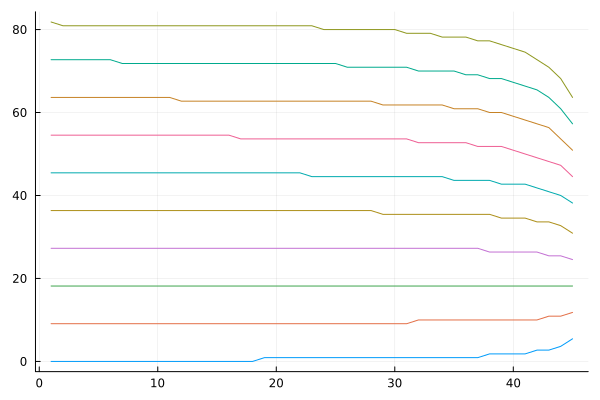

In [6]:
plot(1:pars.T,agrid[A[3,1:10:Ka,:]'],legend=false) # plot the asset policy function every 10 gridpoints for the median wage shock (iϵ=3) over time

In [7]:
df = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    combine(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
end

df2 = @chain data begin
    groupby(:age) # group by age  
    transform(:y => (y -> log.(y)) => :log_y) # take the log of y
    groupby(:age)
    transform(:log_y => mean => :log_y_mean) # calculate the mean of y for each group
    groupby(:age)
    transform([:log_y, :log_y_mean] => ByRow(-) => :resid) # calculate the residuals
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64
1,17118,54000,60000,0.0,49,98,10.8967,11.263,-0.366298
2,12630,61283,224000,39283.0,59,98,11.0233,11.2126,-0.189376
3,12647,42300,28240,0.0,38,98,10.6525,11.0695,-0.416965
4,5239,82275,7500,0.0,56,98,11.3178,11.219,0.0988382
5,2671,69501,48000,3600.0,35,98,11.1491,11.1646,-0.0155507
6,13027,68000,148000,20000.0,49,98,11.1273,11.263,-0.135774
7,6791,93758,80000,160.0,41,98,11.4485,11.1947,0.253742
8,6475,26581,23300,0.0,35,98,10.188,11.1646,-0.976695
9,18332,33785,0,0.0,42,98,10.4278,11.1441,-0.716335


In [8]:
function AR1_process(ρ,ση)
    var = ση^2/(1-ρ^2)
    cov_2 = ρ^2
    cov_4 = ρ^4
    return var, cov_2, cov_4
end

AR1_process (generic function with 1 method)

In [9]:
dlag1 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 2
    @rename :resid_lag1 = :resid
end

dlag2 = @chain df2 begin
    @select :year :person :resid
    @transform :year = :year .+ 4
    @rename :resid_lag2 = :resid
end

ylag1 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 2
    @rename :log_y_lag1 = :log_y
end

ylag2 = @chain df2 begin
    @select :year :person :log_y
    @transform :year = :year .+ 4
    @rename :log_y_lag2 = :log_y
end

data = @chain df2 begin
    innerjoin(dlag1, on = [:person, :year])
    innerjoin(dlag2, on = [:person, :year])
    innerjoin(ylag1, on = [:person, :year])
    innerjoin(ylag2, on = [:person, :year])
end

Row,person,y,tot_assets1,asset,age,year,log_y,log_y_mean,resid,resid_lag1,resid_lag2,log_y_lag1,log_y_lag2
,Int64,Int64,Int64,Float64,Int64,Int64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,17118,43799,-2000,0.0,53,102,10.6874,11.3051,-0.617731,-0.433143,-0.366298,10.8532,10.8967
2,12630,68554,1519000,29454.0,63,102,11.1354,10.9559,0.179507,0.504693,-0.189376,11.5531,11.0233
3,12647,35000,78000,0.0,42,102,10.4631,11.1441,-0.681004,-0.799324,-0.416965,10.3255,10.6525
4,5239,49948,29900,0.0,60,102,10.8187,11.1392,-0.320425,-0.254721,0.0988382,10.9029,11.3178
5,2671,77000,84000,0.0,39,102,11.2516,11.1318,0.119767,0.129348,-0.0155507,11.2252,11.1491
6,13027,91000,248000,25000.0,53,102,11.4186,11.3051,0.113518,-0.453109,-0.135774,10.8332,11.1273
7,6791,122296,118650,154.0,45,102,11.7142,11.2052,0.509001,0.321919,0.253742,11.5179,11.4485
8,18332,54000,56000,0.0,46,102,10.8967,11.2661,-0.369324,-0.622871,-0.716335,10.6016,10.4278
9,3856,95800,357000,9600.0,37,102,11.47,11.0959,0.374122,0.0790909,-0.163537,11.2437,10.9205


In [10]:
estimates = @chain data begin
    @combine begin
        :v_resid = var(:resid)
        :c_resid_1 = cov(:resid, :resid_lag1)
        :c_resid_2 = cov(:resid, :resid_lag2)
    end
end

data_estimates = estimates.v_resid, estimates.c_resid_1, estimates.c_resid_2

([0.6042229503656219], [0.39374914076225126], [0.3537264122186027])

In [27]:
overwrite_μ = @chain data begin
    @groupby(:age)
    @combine(:log_y_mean = mean(:log_y_mean))
end

new_μ = overwrite_μ.log_y_mean

params = (; T = 35, # length of a lifetime
            β = 0.95, # discount factor
            σ = 2.0, # risk aversion
            ρ = 0.2, # persistence of income
            ση = 1.0, # standard deviation of income shocks
            μ = new_μ, # mean of log income (array of size 45 filled with 2.0)
            ψ = 5., # scaling factor in utility from bequest
            r = 0.05 # interest rate
)

Ka = 100
Kϵ = 5
agrid = LinRange(0, 10000 * params.μ[1]*params.T, Ka)   # asset grid LinRange(start, stop, length)
Π, ϵgrid = tauchen(params.ρ, params.ση, Kϵ) # transition matrix and grid for epsilon
params = (; params..., Ka = Ka, agrid = agrid, Π = Π, ϵgrid = ϵgrid, Kϵ = Kϵ) # merge the two dictionaries

V = zeros(params.Kϵ,params.Ka,params.T+1)
A = zeros(Int64,params.Kϵ,params.Ka,params.T)
backward_induction!(V,A,params)
@time backward_induction!(V,A,params)

  0.016921 seconds


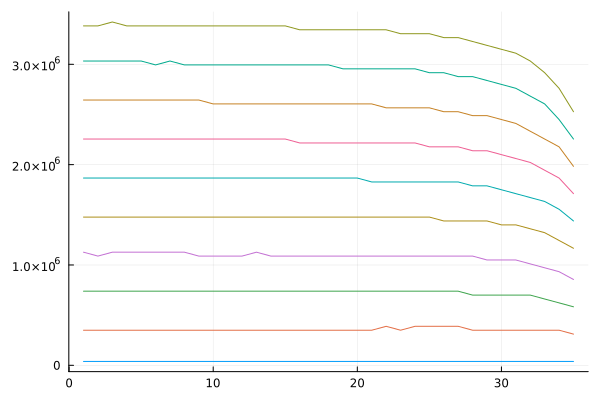

In [28]:
plot(1:params.T,agrid[A[3,1:10:Ka,:]'],legend=false) # plot the asset policy function every 10 gridpoints for the median wage shock (iϵ=3) over time

In [29]:
function ssd(ρ,ση,d)
    var, cov_2, cov_4 = AR1_process(ρ,ση)
    var_data, cov_2_data, cov_4_data = d
    return [(var.-var_data).^2, (cov_2.-cov_2_data).^2, (cov_4.-cov_4_data).^2]
end

function minimise(ρ,ση,d)
    weighted_ssd = ssd(ρ,ση,d)'*I*ssd(ρ,ση,d)
    return weighted_ssd
end

result = optimize(guess -> minimise(guess[1],guess[2],data_estimates), [params.ρ,params.ση], NelderMead())

out_ρ, out_ση = Optim.minimizer(result)

2-element Vector{Float64}:
 0.7061618397012354
 0.5462074067443609

In [30]:
v_first_stage, c1_first_stage, c2_first_stage = AR1_process(out_ρ, out_ση)

(0.5950956141695156, 0.49866454385023323, 0.2486663272933612)

#### **Part 2**

Describe which statistics you are going to try to match using the model. Write a function that takes that dataset and calculates these statistics.

#### **Part 3**

Write a function that:
1. Solves for the optimal savings policies given the estimates $(\hat{\mu}, \hat{\rho},\hat{\sigma}_{\eta})$ and given a guess of the parameters $\beta$ and $\sigma$.
2. Simulates a panel dataset of income and savings outcomes $(y_{n,r,t}, a_{n,r,t})_{n=1,r=1,t=1}^{N,R,T}$. That is, simulate an $N$ x $T$ panel $R$ times. Note that you will have to make an assumption on initial conditions for assets.
3. Calculates the same statistics from the simulated data as you have calculated from the real data.

#### **Part 4**

Write a function that calculates an indirect inference estimate by minimising the difference between the model's implied statistics and those in the data.